In [54]:
%matplotlib inline
import random
import time
from datetime import datetime
import matplotlib.pyplot as plt
import asyncio

## Serial web crawler

In this experiment we are simulating a web crawler that connects to a HTTP server and scrapes some websites. This version of the web crawler does not use concurrency. This crawler scrapes a list of URLs and sums the total lenght of the content from the pages. 

The `DELAY` constant is going to be used to simulate the time the server would take to respond to our query. 

In [41]:
random.seed(0)

In [42]:
log = []

In [43]:
DELAY = 1
def simulate_request(request_number):
    start = time.time()
    time.sleep(DELAY)
    end = time.time()
    log.append([request_number, start, end])
    return random.randint(100, 10001)

In [44]:
def run_experiment(num_iter):
    response_size = 0
    i = 0
    for url in range(num_iter):
        response_size = simulate_request(i)
        i = i + 1
    return response_size

In [45]:
num_iter = 50

start = time.time()
result = run_experiment(num_iter)
end = time.time()
print('Result: {}, Time: {}'.format(result, end - start))

Result: 9398, Time: 50.08742594718933


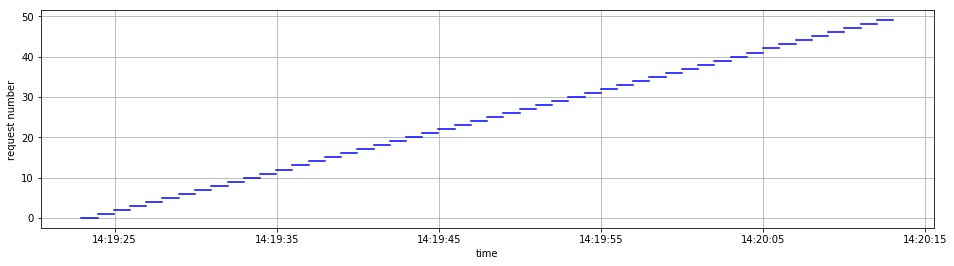

In [53]:
fig, ax = plt.subplots()
for l in log:
    ax.plot([datetime.utcfromtimestamp(l[1]), datetime.utcfromtimestamp(l[2])], 
            [l[0], l[0]], 
            color = 'blue')
ax.set_xlabel('time')
ax.set_ylabel('request number')
ax.grid(True)
fig.set_figwidth(16)

## Asyncio version

In [55]:
random.seed(0)

In [56]:
log = []

In [57]:
DELAY = 1
def simulate_request(request_number):
    start = time.time()
    time.sleep(DELAY)
    end = time.time()
    log.append([request_number, start, end])
    return random.randint(100, 10001)

In [58]:
def run_experiment(num_iter):
    response_size = 0
    i = 0
    for url in range(num_iter):
        response_size = simulate_request(i)
        i = i + 1
    return response_size

In [59]:
num_iter = 50

start = time.time()
result = run_experiment(num_iter)
end = time.time()
print('Result: {}, Time: {}'.format(result, end - start))

Result: 9398, Time: 50.082632064819336
